# Week 40 - Visualizing Attention

## 1. Setup

### 1.1. Libraries

#### 1.1.1. New Libraries

In [1]:
# new libraries for Google Colab
!pip3 install datasets
!pip install datasets==2.2.1 transformers==4.19.1
!pip3 install transformers[torch] # hyperparameters

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 342.2/342.2 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 40.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 106.5 MB/s eta 0:00:00
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.6
    Uninstalling datasets-2.14.6:
      Successfully uninstalled datasets-2.14.6


In [2]:
# Download an Arabic font to be displayed
!wget https://noto-website-2.storage.googleapis.com/pkgs/NotoNaskhArabic-hinted.zip
!unzip NotoNaskhArabic-hinted.zip


# Download a Bengali font to be displayed
!wget https://noto-website-2.storage.googleapis.com/pkgs/NotoSansBengali-hinted.zip
!unzip NotoSansBengali-hinted.zip

--2023-11-02 16:10:14--  https://noto-website-2.storage.googleapis.com/pkgs/NotoNaskhArabic-hinted.zip
Resolving noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)... 172.217.0.91, 172.217.12.27, 2607:f8b0:4025:810::201b, ...
Connecting to noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)|172.217.0.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 477971 (467K) [application/zip]
Saving to: ‘NotoNaskhArabic-hinted.zip’

NotoNaskhArabic-hin 100%[===================>] 466.77K  --.-KB/s    in 0.003s  

2023-11-02 16:10:14 (152 MB/s) - ‘NotoNaskhArabic-hinted.zip’ saved [477971/477971]

Archive:  NotoNaskhArabic-hinted.zip
  inflating: LICENSE_OFL.txt         
  inflating: NotoNaskhArabic-Bold.ttf  
  inflating: NotoNaskhArabic-Regular.ttf  
  inflating: NotoNaskhArabicUI-Bold.ttf  
  inflating: NotoNaskhArabicUI-Regular.ttf  
  inflating: README                  
--2023-11-02 16:10:14--  https://noto-website-

#### 1.1.2. Load Libraries

In [3]:
from google.colab import drive
drive.mount('/content/drive')
import torch
from transformers import AutoModelForSequenceClassification, AutoConfig
from datasets import load_dataset                                                    # library to import data from huggingface
import matplotlib.pyplot as plt
import numpy as np                                                                   # library for math operations and matrices
import matplotlib.font_manager as fm
from transformers import  AutoTokenizer, AutoModelForSequenceClassification    # transformer: optimizer, tokenizer (pre-train model), model
from transformers import AutoModelForTokenClassification

#import pandas as pd                                                                  # library to transform to dataframe. helps for statistics
#from bpemb import BPEmb                                                              # embeddings
#from sklearn.linear_model import LogisticRegression                                  # model
#import warnings                                                                      # ignore warnings in printing
#warnings.filterwarnings("ignore")
#from sklearn.metrics import classification_report                                    # classification report binary clasiffier
#from sklearn.metrics import f1_score, accuracy_score                                 # f1_score, accuracy
#from sklearn.metrics import recall_score, precision_score                            # recall_score, precision_score
#import torch                                                                         # torch for managing special python objects
#from torch import nn                                                                 # neural networks
#from torch.utils.data import Dataset, DataLoader                                     # torch for managing special data types
#from typing import List, Tuple                                                       # data structures in outputs
#from tqdm.notebook import tqdm                                                       # show progress of the loop
#
#from transformers import BertForSequenceClassification                               # Load trained model
#from transformers import DataCollatorWithPadding                                     # for padding in batches
#from transformers import TrainingArguments                                           # Hyperparametes
#from transformers import Trainer                                                     # Trainer
#from datasets import load_metric                                                     # Evaluation metric
#


Mounted at /content/drive


### 1.2. Data

#### 1.2.1. Read Data

In [4]:
languages = ['arabic', 'bengali', 'indonesian']

# load training dataset
datasets_train = load_dataset("copenlu/answerable_tydiqa", split='train')
# load validation dataset
datasets_val = load_dataset("copenlu/answerable_tydiqa", split='validation')
# set gpu if available
device = "cuda:0" if torch.cuda.is_available() else "cpu"

Downloading:   0%|          | 0.00/2.47k [00:00<?, ?B/s]

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/copenlu___parquet/copenlu--nlp_course_tydiqa-42333912ea665dd0/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901. Subsequent calls will reuse this data.


## 2. Attention

### 2.1. Binary Attention

#### 2.1.1. Functions

In [5]:
def plot_attention(attention, input_ids, tokenizer, n_tokens=None, save_path=None,
                   prop=fm.FontProperties(fname='NotoNaskhArabic-Regular.ttf'),
                   latin=False):
    # attention: attention weights for specific layer and head ([sequence_length, sequence_length])
    # input_ids: token ids of the input sequence ([sequence_length])
    # tokenizer: the tokenizer used for decoding token ids
    # n_tokens: number of tokens to display in the plot

    if n_tokens is None:
        n_tokens = len(input_ids)  # Display all tokens

    attention = attention[:n_tokens, :n_tokens]  # select the first n_tokens x n_tokens

    # Convert input ids to tokens
    tokens = tokenizer.convert_ids_to_tokens(input_ids)

    # Print out the tokens for translation
    print("Tokens:")
    for token in tokens[:n_tokens]:
        print(token)

    # Create the plot
    fig, ax = plt.subplots(figsize=(8, 8))
    cax = ax.matshow(attention, cmap='viridis')  # heatmap
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticks(np.arange(n_tokens))
    ax.set_yticks(np.arange(n_tokens))
    if not latin:
      ax.set_xticklabels(tokens[:n_tokens], rotation=90, fontproperties=prop)
      ax.set_yticklabels(tokens[:n_tokens], fontproperties=prop)
    else:
      ax.set_xticklabels(tokens[:n_tokens], rotation=90)
      ax.set_yticklabels(tokens[:n_tokens])



    # Save or display
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)  # save the figure
    else:
        plt.show()

In [6]:
def perturb_and_predict(input_ids, tokenizer, model, indices_to_mask):
    perturbed_input = input_ids.clone()
    for idx in indices_to_mask:
        perturbed_input[0][idx] = tokenizer.convert_tokens_to_ids('[MASK]')

    logits = model(perturbed_input).logits
    return logits.argmax(dim=-1).item()

In [7]:
def tokenize_function(dataset_, variable1= 'question_text', variable2= 'document_plaintext'):
    """
    Use together question and document to create the tokenizer object
    that will be input of the model
    - We don't pad here but later in the batches.
    - We truncate as the length of text how the model learnt
    """
    return tokenizer(dataset_["question_text"], dataset_["document_plaintext"], truncation=True)

#### 2.1.2. Arabic

In [9]:
model_directory = "Week 38/TRANSFORMER TRAINED MODELS/Week 38 - BERT - ARABIC"
#Load the model
config = AutoConfig.from_pretrained(model_directory, output_attentions=True)
tokenizer = AutoTokenizer.from_pretrained(model_directory)
model = AutoModelForSequenceClassification.from_pretrained(model_directory, config=config)


In [10]:
# Apply the tokenizer to the questions+document in train and val datasets
datasets_val_tokenize = datasets_val.map(tokenize_function, batched=True)
datasets_val_tokenize_filter = datasets_val_tokenize.filter(lambda dataset: dataset["language"]==languages[0])

  0%|          | 0/14 [00:00<?, ?ba/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

In [37]:
# Selecting the first instance in the validation set for demonstration
instance = datasets_val_tokenize_filter[0]
inputs = {}
inputs['input_ids'] = torch.Tensor([x for x in instance['input_ids']]).int().unsqueeze(0)
inputs['token_type_ids'] = torch.Tensor([x for x in instance['token_type_ids']]).int().unsqueeze(0)
inputs['attention_mask'] = torch.Tensor([x for x in instance['attention_mask']]).int().unsqueeze(0)


In [38]:
outputs = model(**inputs)
attentions = outputs.attentions  # Retrieve the attention values

Tokens:
[CLS]
كم
عدد
مرات
ف
##وز
الا
##ورو
##غو
##اي
ب
##بط
##ولة
كاس
العالم
ل
##كر
##و
القدم
؟
[SEP]
ا
##قيم
##ت
البطولة
21
مرة
،
شارك
في
النهايي
##ات
78
دولة
،
وعدد
الف
##رق
التي
فاز
##ت
با
##لب
##طول
##ة
حتى
الان
8
فرق
،
و
##يع
##د
ال
##من
##تخب
ال
##بر
##از
##يلي
الاكثر
ت
##تو
##يج
##ا
با
##لك
##اس
حيث
فاز
بها
5
مرات
ا
##ع
##وام
:
1958
،
1962
،
1970
،
1994
و
##200
##2
.
يلي
##ه
ال
##من
##تخب
الا
##يط
##الي
الذي
ا
##حر
##زه


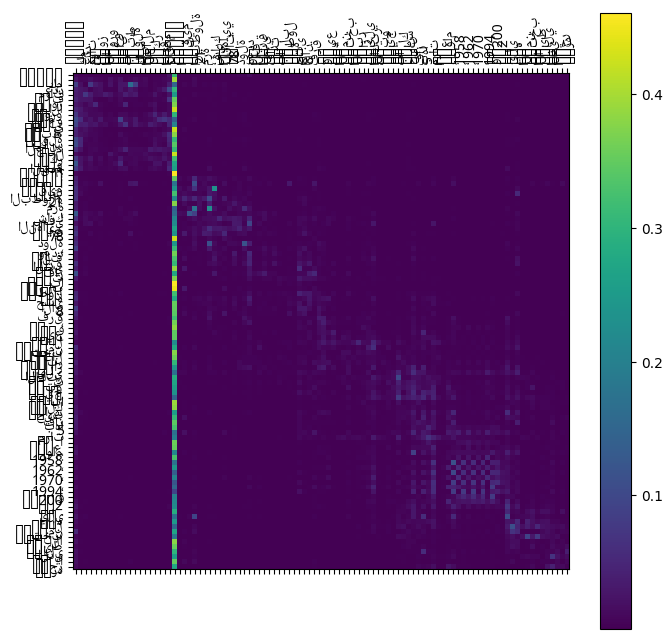

In [39]:
# Load the Arabic font
prop = fm.FontProperties(fname='NotoNaskhArabic-Regular.ttf')

# Choose a specific layer and head
layer = 4
head = 0

# Retrieve the attention of the specific head in the chosen layer
attention_layer = attentions[layer]  # get the attention values for the specified layer
attention_head = attention_layer[0, head, :, :]  # (1, num_heads, seq_length, seq_length) -> (seq_length, seq_length)

# Select a subset of tokens to visualize
n_tokens = 100  # the first 100 tokens

plot_attention(attention_head.detach().numpy(), inputs['input_ids'][0][:n_tokens], tokenizer, n_tokens)

In [34]:
# Model prediction
logits = model(inputs['input_ids']).logits
original_prediction = logits.argmax(dim=-1).item()

# Sum attention scores for each token
attention_sums = attention_head.detach().numpy().sum(axis=1)

# Get the indices of the top N tokens with the highest attention
N = 73  # mask the top n tokens
top_attention_indices = attention_sums.argsort()[-N:][::-1]


# Convert the tensor to a numpy array for easier access
input_ids_array = inputs['input_ids'][0].cpu().numpy()

# Print the tokens that we're going to mask
print("Tokens to mask:", [tokenizer.convert_ids_to_tokens([input_ids_array[idx]])[0] for idx in top_attention_indices])

# Perturb the input by masking the identified tokens and get prediction
perturbed_prediction = perturb_and_predict(inputs['input_ids'], tokenizer, model, top_attention_indices)

print("Original Prediction:", original_prediction)
print("Prediction after masking high-attention tokens:", perturbed_prediction)

Tokens to mask: ['##ش', ')', 'عام', 'نظام', '##سي', 'ال', '##سم', 'ب', 'كان', '##ول', 'ز', ':', 'الالمانية', '##كية', '##زية', 'جوان', '##يت', 'او', 'فيها', 'الحياة', '##س', '##يخ', '.', '##يخ', 'الالماني', 'الفترة', 'و', '"', 'را', '##س', 'ال', 'الى', 'الحرب', 'ه', '[SEP]', 'بعد', 'تحت', '##به', 'ان', 'حكم', 'ي', '##ت', '؟', 'ال', '##نا', '##ر', '##ت', '##را', 'المانيا', '##ولة', '-', '##وت', '.', '##س', 'ل', 'را', '##يش', '"', 'الحزب', 'سنة', 'اسم', 'حتى', '1943', '##يا', '##تور', '##حكم', '##ك', 'غ', '##زي', 'بينما', 'الرسمي', 'الاسم', 'است']
Original Prediction: 1
Prediction after masking high-attention tokens: 1


#### 2.1.3. Bengali

In [ ]:
model_directory = "Week 38/TRANSFORMER TRAINED MODELS/Week 38 - BERT - BENGALI"
#Load the model
config = AutoConfig.from_pretrained(model_directory, output_attentions=True)
tokenizer = AutoTokenizer.from_pretrained(model_directory)
model = AutoModelForSequenceClassification.from_pretrained(model_directory, config=config)


In [ ]:
# Apply the tokenizer to the questions+document in train and val datasets
datasets_val_tokenize = datasets_val.map(tokenize_function, batched=True)
datasets_val_tokenize_filter = datasets_val_tokenize.filter(lambda dataset: dataset["language"]==languages[1])

  0%|          | 0/14 [00:00<?, ?ba/s]

In [ ]:
# Selecting the first instance in the validation set for demonstration
instance = datasets_val_tokenize_filter[0]
inputs = {}
inputs['input_ids'] = torch.Tensor([x for x in instance['input_ids']]).int().unsqueeze(0)
inputs['token_type_ids'] = torch.Tensor([x for x in instance['token_type_ids']]).int().unsqueeze(0)
inputs['attention_mask'] = torch.Tensor([x for x in instance['attention_mask']]).int().unsqueeze(0)


In [ ]:
outputs = model(**inputs)
attentions = outputs.attentions  # Retrieve the attention values

[CLS]
পশচিম
ভারতের
ম
##হার
##া
##ষট
##র
রাজযের
ম
##ম
##বা
##ই
শহর
##ে
ন
##ির
##মিত
গ
##েট
##ও
##যে
অব
ই
##নড
##িযা
স
##থা
##পত
##য
##টির
ভ
##িত
##তি
##পর
##সত
##র
স
##থা
##পন
করেন
কে
?
[SEP]
দ
##িল
##লী
দ
##র
##বার
ত
##ৈ
##রী
##র
পরবে
,
গ
##েট
##ও
##যে
অব
ই
##নড
##িযা
১৯
##১
##১
সালে
ক
##িং
জ
##র
##জ
ফ
##াই
##ভ
এবং
ক
##নি
মে
##রি
ম
##ম
##বা
##ই
আগ
##মন
##ের
স
##ম
##তি
র
##কষা
##র
##থে
ন
##ির
##মাণ
করা
হযেছিল


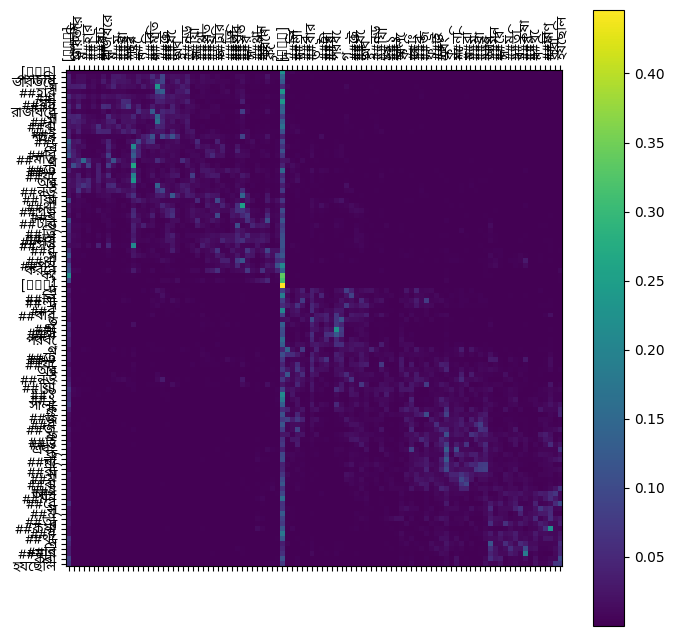

In [ ]:
prop = fm.FontProperties(fname='NotoSansBengali-Regular.ttf')

# Choose a specific layer and head
layer = 4  #the 5th layer
head = 0  #the 1st head

# Retrieve the attention of the specific head in the chosen layer
attention_layer = attentions[layer]  # get the attention values for the specified layer
attention_head = attention_layer[0, head, :, :]  # (1, num_heads, seq_length, seq_length) -> (seq_length, seq_length)

# Select a subset of tokens to visualize
n_tokens = 100  # the first 50 tokens

plot_attention(attention_head.detach().numpy(), inputs['input_ids'][0][:n_tokens], tokenizer, n_tokens)

In [ ]:
# Model prediction
logits = model(inputs['input_ids']).logits
original_prediction = logits.argmax(dim=-1).item()

# Sum attention scores for each token
attention_sums = attention_head.detach().numpy().sum(axis=1)

# Get the indices of the top N tokens with the highest attention
N = 150  # mask the top n tokens
top_attention_indices = attention_sums.argsort()[-N:][::-1]


# Convert the tensor to a numpy array for easier access
input_ids_array = inputs['input_ids'][0].cpu().numpy()

# Print the tokens that we're going to mask
print("Tokens to mask:", [tokenizer.convert_ids_to_tokens([input_ids_array[idx]])[0] for idx in top_attention_indices])

# Perturb the input by masking the identified tokens and get prediction
perturbed_prediction = perturb_and_predict(inputs['input_ids'], tokenizer, model, top_attention_indices)

print("Original Prediction:", original_prediction)
print("Prediction after masking high-attention tokens:", perturbed_prediction)

Tokens to mask: ['##ম', '১৯', 'এই', 'ন', '13', '##নড', '##মে', '।', 'আর', 'পরবে', 'ফ', '১৯', '##ার', 'করেন', '##পন', '##১', 'ক', 'চ', '##া', '##পত', '##মিত', 'প', '##তে', 'এবং', '১৯', '##যে', '##মাণ', '##িযা', 'ন', '##নড', '##ট', '##টির', 'তারা', 'কে', ',', '##যে', 'অ', 'দিযে', 'শর', '##শে', '১৯', '##পন', 'কিনত', '##বা', '##ং', '##ন', 'ম', '##হ', '##বার', 'ডিসেমবর', 'গ', 'রাজযের', '##ম', '##থা', 'ম', 'উ', '##রি', 'মে', '##হার', '##শে', 'ক', '##ম', '##সর', '##র', '##জ', 'জ', '##ৈ', '##ির', 'ন', '##জ', 'হয', '##তি', '##াম', 'হযেছিল', '##ও', 'সালের', 'স', '##ক', 'পরে', '##র', 'সরকার', 'স', ']', '##র', '##ডে', 'গ', 'ত', 'ব', '11', 'যে', '##১', '##ের', '##িং', 'করা', '##মাণ', '##থে', '##কষা', 'র', 'স', '##মন', '##থা', 'আগ', 'জ', '##ম', '##নি', 'ক', 'এবং', '##ভ', 'স', '##১', '##যে', '##খে', '##ির', '##না', '##ন', '##ছিলেন', '##ে', '##ের', '##১', 'ই', '##টির', 'দ', '##নড', '##িযা', '১৯', '##ড', '##ধ', 'শ', 'দ', '##ো', '##লী', 'এবং', 'সালে', '##৪', '##২', 'হযেছিল', '##হ', '##ে', 'শ', 'কাজ', '

#### 2.1.4. Indonesian

In [ ]:
model_directory = "Week 38/TRANSFORMER TRAINED MODELS/Week 38 - BERT - INDONESIAN"
#Load the model
config = AutoConfig.from_pretrained(model_directory, output_attentions=True)
tokenizer = AutoTokenizer.from_pretrained(model_directory)
model = AutoModelForSequenceClassification.from_pretrained(model_directory, config=config)


In [ ]:
# Apply the tokenizer to the questions+document in train and val datasets
datasets_val_tokenize = datasets_val.map(tokenize_function, batched=True)
datasets_val_tokenize_filter = datasets_val_tokenize.filter(lambda dataset: dataset["language"]==languages[2])

  0%|          | 0/14 [00:00<?, ?ba/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

In [ ]:
# Selecting the first instance in the validation set for demonstration
instance = datasets_val_tokenize_filter[0]
inputs = {}
inputs['input_ids'] = torch.Tensor([x for x in instance['input_ids']]).int().unsqueeze(0)
inputs['token_type_ids'] = torch.Tensor([x for x in instance['token_type_ids']]).int().unsqueeze(0)
inputs['attention_mask'] = torch.Tensor([x for x in instance['attention_mask']]).int().unsqueeze(0)


In [ ]:
outputs = model(**inputs)
attentions = outputs.attentions  # Retrieve the attention values

Tokens:
[CLS]
sia
##pak
##ah
yang
mene
##mu
##ka
ben
##ua
amerika
?
[SEP]
kol
##um
##bus
bukan
##lah
orang
pertama
yang
tiba
di
amerika
,
yang
ia
dapat
##i
sudah
did
##udu
##ki
.
ia
juga
bukan
orang
eropa
pertama
yang
sampai
ke
ben
##ua
itu
karena
sekarang
telah
dia
##kui
secara
mel
##uas
bahwa
orang
-
orang
viking
dari
eropa
utara
telah
ber
##kun
##jung
ke
amerika
utara
pada
abad
ke
11
dan
mendirikan
koloni
l
'
ans
##e
aux
meadows
untuk
jang
##ka
waktu
sing
##kat
.
terdapat
per
##kira
##an
bahwa
pela
##yar
yang
tidak
dikenali
pernah


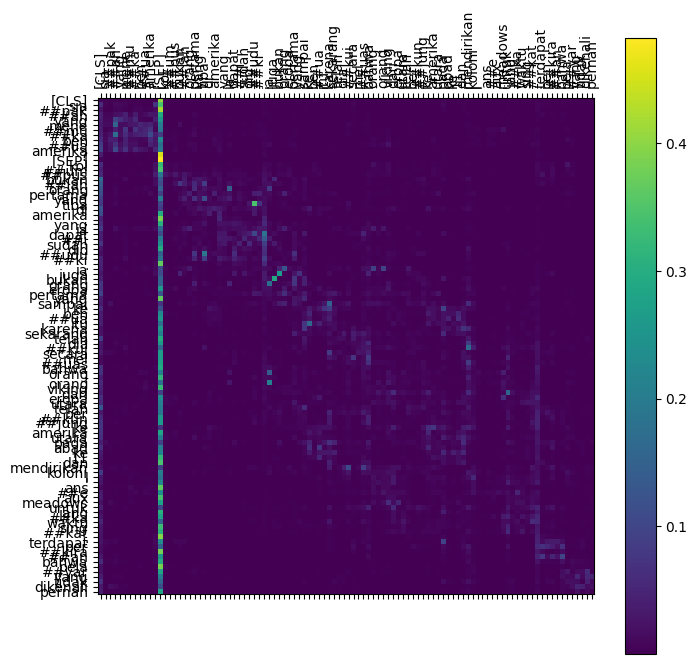

In [ ]:
# Choose a specific layer and head
layer = 4  # the 5th layer
head = 0  # the 1st head

# Retrieve the attention of the specific head in the chosen layer
attention_layer = attentions[layer]  # get the attention values for the specified layer
attention_head = attention_layer[0, head, :, :]  # (1, num_heads, seq_length, seq_length) -> (seq_length, seq_length)

# Select a subset of tokens to visualize
n_tokens = 100  # the first 50 tokens

plot_attention(attention_head.detach().numpy(),
               inputs['input_ids'][0][:n_tokens],
               tokenizer,
               n_tokens,
               latin=True)


In [ ]:
# Model prediction
logits = model(inputs['input_ids']).logits
original_prediction = logits.argmax(dim=-1).item()

# Sum attention scores for each token
attention_sums = attention_head.detach().numpy().sum(axis=1)

# Get the indices of the top N tokens with the highest attention
N = 150  # mask the top n tokens
top_attention_indices = attention_sums.argsort()[-N:][::-1]


# Convert the tensor to a numpy array for easier access
input_ids_array = inputs['input_ids'][0].cpu().numpy()

# Print the tokens that we're going to mask
print("Tokens to mask:", [tokenizer.convert_ids_to_tokens([input_ids_array[idx]])[0] for idx in top_attention_indices])

# Perturb the input by masking the identified tokens and get prediction
perturbed_prediction = perturb_and_predict(inputs['input_ids'], tokenizer, model, top_attention_indices)

print("Original Prediction:", original_prediction)
print("Prediction after masking high-attention tokens:", perturbed_prediction)

Tokens to mask: ['ke', 'bahwa', 'di', 'ben', 'sing', 'ke', '##ua', 'telah', 'kol', '##um', 'dan', 'tiba', 'dia', 'telah', 'aux', 'yang', 'bukan', 'orang', '11', '##jung', '##ki', 'orang', '.', 'pada', '##lah', '##udu', '##ua', 'dan', 'mendirikan', 'bukan', 'l', '##bus', 'did', 'ans', '##um', '##kun', 'dapat', 'itu', 'yang', 'karena', 'sekarang', 'ke', 'sampai', '##kui', 'secara', 'mel', '##uas', '-', 'kol', ',', 'eropa', 'dari', 'orang', 'eropa', 'utara', 'jang', 'untuk', 'banyak', '##kannya', 'dengan', 'sumber', 'untuk', 'ke', '##jaya', '##annya', 'ben', '##ka', 'juga', 'mene', '##al', 'eks', 'yang', '##ah', '##pak', 'amerika', 'oleh', 'berbagai', 'sepanjang', 'masa', 'sia', '##i', 'sudah', '##bek', 'yang', 'terdapat', 'per', '##kira', '##an', 'bahwa', 'pela', 'mem', '[SEP]', 'amerika', '.', 'dikenali', 'pernah', 'mela', '##ka', 'ke', 'amerika', 'sebelum', '##bus', '##kat', '?', 'ia', 'yang', '##mu', 'pertama', 'amerika', '[SEP]', '##ped', '##isi', '##yar', 'waktu', 'teori', 'koloni',

### 2.2. Sequence Attention

#### 2.2.1. Arabic

In [ ]:
model_directory = "Week 39/BERT-SEQUENCE LABELS/models/BERT - ARABIC - SEQUENCE"
#Load the model
config = AutoConfig.from_pretrained(model_directory, output_attentions=True)
tokenizer = AutoTokenizer.from_pretrained(model_directory)
model = AutoModelForTokenClassification.from_pretrained(model_directory, config=config)


In [ ]:
# Apply the tokenizer to the questions+document in train and val datasets
datasets_val_filter = datasets_val.filter(lambda dataset: dataset["language"]==languages[0])

  0%|          | 0/14 [00:00<?, ?ba/s]

In [ ]:
# Selecting the first instance in the validation set for demonstration
instance = datasets_val_filter[0]

batch = tokenizer(
      instance['question_text'],
      instance['document_plaintext'],
      truncation="only_second",
      stride=128,
      return_overflowing_tokens=True,
      return_offsets_mapping=True,
      padding="max_length",
  )

In [ ]:
inputs = {}
inputs['input_ids'] = torch.Tensor([x for x in batch['input_ids']]).int()
inputs['attention_mask'] = torch.Tensor([x for x in batch['attention_mask']]).int()


In [ ]:
outputs = model(**inputs)
attentions = outputs.attentions  # Retrieve the attention values

Tokens:
[CLS]
كم
عدد
مرات
ف
##وز
الا
##ورو
##غو
##اي
ب
##بط
##ولة
كاس
العالم
ل
##كر
##و
القدم
؟
[SEP]
ا
##قيم
##ت
البطولة
21
مرة
،
شارك
في
النهايي
##ات
78
دولة
،
وعدد
الف
##رق
التي
فاز
##ت
با
##لب
##طول
##ة
حتى
الان
8
فرق
،
و
##يع
##د
ال
##من
##تخب
ال
##بر
##از
##يلي
الاكثر
ت
##تو
##يج
##ا
با
##لك
##اس
حيث
فاز
بها
5
مرات
ا
##ع
##وام
:
1958
،
1962
،
1970
،
1994
و
##200
##2
.
يلي
##ه
ال
##من
##تخب
الا
##يط
##الي
الذي
ا
##حر
##زه


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 108 (l) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 112 (p) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 91 ([) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 67 (C) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 76 (L) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 83 (S) missing from current font.
  fig.canvas.print_figure(bytes_io, **

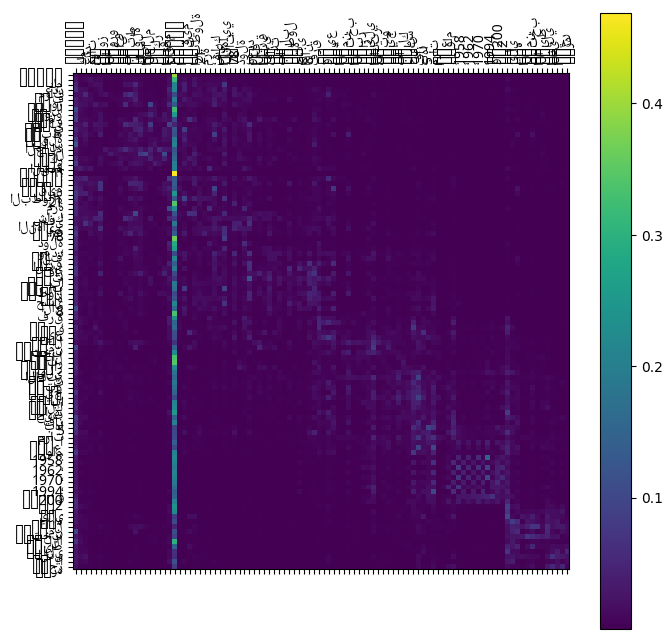

In [ ]:
# Load the Arabic font
prop = fm.FontProperties(fname='NotoNaskhArabic-Regular.ttf')

# Choose a specific layer and head
layer = 4
head = 0

# Retrieve the attention of the specific head in the chosen layer
attention_layer = attentions[layer]  # get the attention values for the specified layer
attention_head = attention_layer[0, head, :, :]  # (1, num_heads, seq_length, seq_length) -> (seq_length, seq_length)

# Select a subset of tokens to visualize
n_tokens = 100  # the first 100 tokens

plot_attention(attention_head.detach().numpy(), inputs['input_ids'][0][:n_tokens], tokenizer, n_tokens)

#### 2.2.2. Bengali

In [ ]:
model_directory = "Week 39/BERT-SEQUENCE LABELS/models/BERT - BENGALI - SEQUENCE"
#Load the model
config = AutoConfig.from_pretrained(model_directory, output_attentions=True)
tokenizer = AutoTokenizer.from_pretrained(model_directory)
model = AutoModelForTokenClassification.from_pretrained(model_directory, config=config)


In [ ]:
# Apply the tokenizer to the questions+document in train and val datasets
datasets_val_filter = datasets_val.filter(lambda dataset: dataset["language"]==languages[1])

  0%|          | 0/14 [00:00<?, ?ba/s]

In [ ]:
# Selecting the first instance in the validation set for demonstration
instance = datasets_val_filter[0]

batch = tokenizer(
      instance['question_text'],
      instance['document_plaintext'],
      truncation="only_second",
      stride=128,
      return_overflowing_tokens=True,
      return_offsets_mapping=True,
      padding="max_length",
  )

In [ ]:
inputs = {}
inputs['input_ids'] = torch.Tensor([x for x in batch['input_ids']]).int()
inputs['attention_mask'] = torch.Tensor([x for x in batch['attention_mask']]).int()


In [ ]:
outputs = model(**inputs)
attentions = outputs.attentions  # Retrieve the attention values

Tokens:
[CLS]
পশচিম
ভারতের
ম
##হার
##া
##ষট
##র
রাজযের
ম
##ম
##বা
##ই
শহর
##ে
ন
##ির
##মিত
গ
##েট
##ও
##যে
অব
ই
##নড
##িযা
স
##থা
##পত
##য
##টির
ভ
##িত
##তি
##পর
##সত
##র
স
##থা
##পন
করেন
কে
?
[SEP]
দ
##িল
##লী
দ
##র
##বার
ত
##ৈ
##রী
##র
পরবে
,
গ
##েট
##ও
##যে
অব
ই
##নড
##িযা
১৯
##১
##১
সালে
ক
##িং
জ
##র
##জ
ফ
##াই
##ভ
এবং
ক
##নি
মে
##রি
ম
##ম
##বা
##ই
আগ
##মন
##ের
স
##ম
##তি
র
##কষা
##র
##থে
ন
##ির
##মাণ
করা
হযেছিল


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2474 (\N{BENGALI LETTER PA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Matplotlib currently does not support Bengali natively.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2486 (\N{BENGALI LETTER SHA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2458 (\N{BENGALI LETTER CA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2495 (\N{BENGALI VOWEL SIGN I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pyla

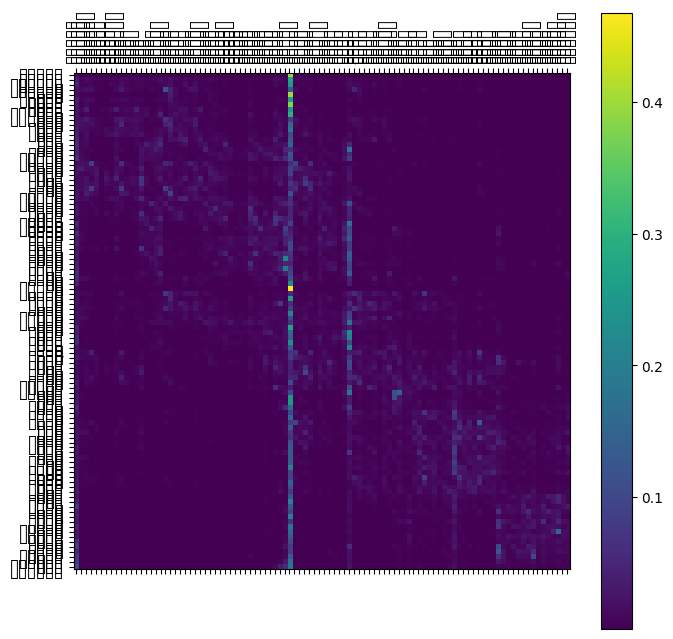

In [ ]:
# Choose a specific layer and head
layer = 4
head = 0

# Retrieve the attention of the specific head in the chosen layer
attention_layer = attentions[layer]  # get the attention values for the specified layer
attention_head = attention_layer[0, head, :, :]  # (1, num_heads, seq_length, seq_length) -> (seq_length, seq_length)

# Select a subset of tokens to visualize
n_tokens = 100  # the first 100 tokens

plot_attention(attention_head.detach().numpy(), inputs['input_ids'][0][:n_tokens], tokenizer, n_tokens)

#### 2.2.3. Indonesian

In [ ]:
model_directory = "Week 39/BERT-SEQUENCE LABELS/models/BERT - INDONESIAN - SEQUENCE"
#Load the model
config = AutoConfig.from_pretrained(model_directory, output_attentions=True)
tokenizer = AutoTokenizer.from_pretrained(model_directory)
model = AutoModelForTokenClassification.from_pretrained(model_directory, config=config)


In [ ]:
# Apply the tokenizer to the questions+document in train and val datasets
datasets_val_filter = datasets_val.filter(lambda dataset: dataset["language"]==languages[2])

  0%|          | 0/14 [00:00<?, ?ba/s]

In [ ]:
# Selecting the first instance in the validation set for demonstration
instance = datasets_val_filter[0]

batch = tokenizer(
      instance['question_text'],
      instance['document_plaintext'],
      truncation="only_second",
      stride=128,
      return_overflowing_tokens=True,
      return_offsets_mapping=True,
      padding="max_length",
  )

In [ ]:
inputs = {}
inputs['input_ids'] = torch.Tensor([x for x in batch['input_ids']]).int()
inputs['attention_mask'] = torch.Tensor([x for x in batch['attention_mask']]).int()


In [ ]:
outputs = model(**inputs)
attentions = outputs.attentions  # Retrieve the attention values

Tokens:
[CLS]
sia
##pak
##ah
yang
mene
##mu
##ka
ben
##ua
amerika
?
[SEP]
kol
##um
##bus
bukan
##lah
orang
pertama
yang
tiba
di
amerika
,
yang
ia
dapat
##i
sudah
did
##udu
##ki
.
ia
juga
bukan
orang
eropa
pertama
yang
sampai
ke
ben
##ua
itu
karena
sekarang
telah
dia
##kui
secara
mel
##uas
bahwa
orang
-
orang
viking
dari
eropa
utara
telah
ber
##kun
##jung
ke
amerika
utara
pada
abad
ke
11
dan
mendirikan
koloni
l
'
ans
##e
aux
meadows
untuk
jang
##ka
waktu
sing
##kat
.
terdapat
per
##kira
##an
bahwa
pela
##yar
yang
tidak
dikenali
pernah


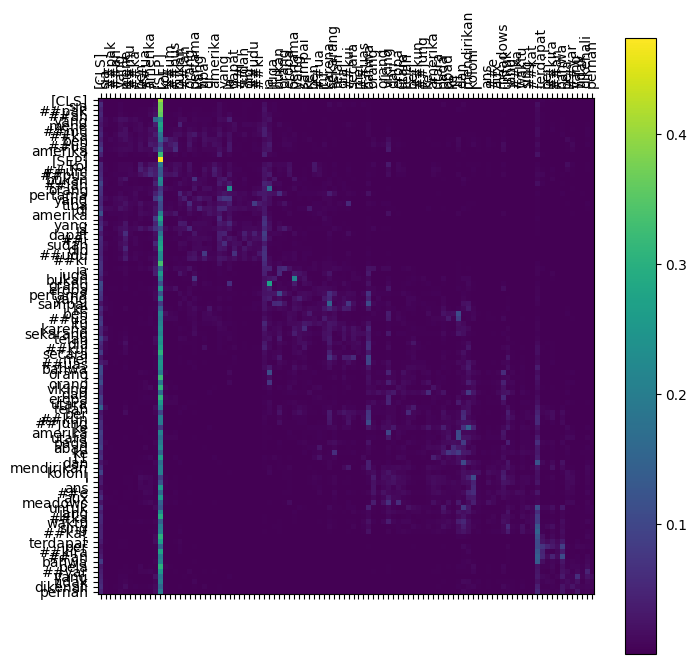

In [ ]:
# Choose a specific layer and head
layer = 4
head = 0

# Retrieve the attention of the specific head in the chosen layer
attention_layer = attentions[layer]  # get the attention values for the specified layer
attention_head = attention_layer[0, head, :, :]  # (1, num_heads, seq_length, seq_length) -> (seq_length, seq_length)

# Select a subset of tokens to visualize
n_tokens = 100  # the first 100 tokens

plot_attention(attention_head.detach().numpy(), inputs['input_ids'][0][:n_tokens], tokenizer, n_tokens,latin=True)